# Project 3 Team 5
## Date: 17 January 2025 

1. Project Overview
2. Data Load and preprocessing
3. Model training
4. Evaluation
5. Deployment

### 1. Project Overview

### 2. Data load and preprocessing 
#### Packages

In [ ]:
pip install scikeras

In [ ]:
pip install tensorflow

In [9]:
pip install mlflow

   ---------------------------------------- 0.0/28.3 MB ? eta -:--:--
    --------------------------------------- 0.4/28.3 MB 9.2 MB/s eta 0:00:04
   - -------------------------------------- 0.8/28.3 MB 8.1 MB/s eta 0:00:04
   - -------------------------------------- 1.1/28.3 MB 7.6 MB/s eta 0:00:04
   - -------------------------------------- 1.4/28.3 MB 7.2 MB/s eta 0:00:04
   -- ------------------------------------- 1.7/28.3 MB 7.1 MB/s eta 0:00:04
   -- ------------------------------------- 2.0/28.3 MB 7.0 MB/s eta 0:00:04
   --- ------------------------------------ 2.3/28.3 MB 7.0 MB/s eta 0:00:04
   --- ------------------------------------ 2.6/28.3 MB 7.0 MB/s eta 0:00:04
   ---- ----------------------------------- 2.9/28.3 MB 6.9 MB/s eta 0:00:04
   ---- ----------------------------------- 3.3/28.3 MB 6.9 MB/s eta 0:00:04
   ----- ---------------------------------- 3.6/28.3 MB 6.9 MB/s eta 0:00:04
   ----- ---------------------------------- 3.9/28.3 MB 6.9 MB/s eta 0:00:04
   ---

In [ ]:
pip install --upgrade imbalanced-learn

In [409]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn 
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import mlflow
import mlflow.sklearn
import scikeras
from scikeras.wrappers import KerasClassifier
import pickle
from mlflow.models import infer_signature

from urllib.parse import urlparse
import json
from scipy.sparse import csr_matrix
import joblib

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from scipy.sparse import csr_matrix, vstack

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, normalize

import nltk
import re
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ThandoCalana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ThandoCalana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ThandoCalana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ThandoCalana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Datasets

In [308]:
#importing the dataset:the train dataset 
train_df = pd.read_csv("Data/processed/train.csv")
# train_df.head(5)

In [309]:
#importing the dataset: the test 
test_df = pd.read_csv("Data/processed/test.csv")
# test_df.head(5)

<h3>2.1 Data inspection</h3>

In [4]:
print("The dimensions for the Train set are:", train_df.shape)
print("The dimensions for the test set are:",test_df.shape)

The dimensions for the Train set are: (5520, 5)
The dimensions for the test set are: (2000, 5)


In [5]:
display(train_df.info(), test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5520 entries, 0 to 5519
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   headlines    5520 non-null   object
 1   description  5520 non-null   object
 2   content      5520 non-null   object
 3   url          5520 non-null   object
 4   category     5520 non-null   object
dtypes: object(5)
memory usage: 215.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   headlines    2000 non-null   object
 1   description  2000 non-null   object
 2   content      2000 non-null   object
 3   url          2000 non-null   object
 4   category     2000 non-null   object
dtypes: object(5)
memory usage: 78.3+ KB


None

None

There are no missing values in both the train and test dataset

In [6]:
null_counts = pd.DataFrame({
    "Train Null Count": train_df.isnull().sum(),
    "Test Null Count": test_df.isnull().sum()
})
print(null_counts)

             Train Null Count  Test Null Count
headlines                   0                0
description                 0                0
content                     0                0
url                         0                0
category                    0                0


In [7]:
display(train_df.duplicated().sum(), test_df.duplicated().sum())

0

0

Number of duplicate for train set rows: 0

Number of duplicate for test set rows: 0

In [8]:
def inspect_dataset(df):
    return {
        "Number of Rows": df.shape[0],
        "Number of Columns": df.shape[1],
        "Total Missing Values": df.isnull().sum().sum(),
        "Duplicate Rows": df.duplicated().sum(),
        "Numerical Columns": df.select_dtypes(include='number').shape[1],
        "Categorical Columns": df.select_dtypes(include='object').shape[1],
    }

train_inspection = inspect_dataset(train_df)
test_inspection = inspect_dataset(test_df)

inspection_results = pd.DataFrame({
    "Metric": train_inspection.keys(),
    "Train Dataset": train_inspection.values(),
    "Test Dataset": test_inspection.values(),
})

print(inspection_results)

                 Metric  Train Dataset  Test Dataset
0        Number of Rows           5520          2000
1     Number of Columns              5             5
2  Total Missing Values              0             0
3        Duplicate Rows              0             0
4     Numerical Columns              0             0
5   Categorical Columns              5             5


In [9]:
train_df.describe().T
#check if there are duplicates 

,count,unique,top,freq
headlines,5520,5512,International Education Day 2024: Know why it ...,2
description,5520,5508,The university has removed the requirements of...,2
content,5520,5513,Grand Slam fever grips tennis fans all over th...,5
url,5520,5514,https://indianexpress.com/article/education/kc...,2
category,5520,5,education,1520


In [10]:
categories = train_df.category.unique()
print(test_df.head())

                                           headlines  \
0  NLC India wins contract for power supply to Ra...   
1  SBI Clerk prelims exams dates announced; admit...   
2  Golden Globes: Michelle Yeoh, Will Ferrell, An...   
3  OnePlus Nord 3 at Rs 27,999 as part of new pri...   
4  Adani family’s partners used ‘opaque’ funds to...   

                                         description  \
0  State-owned firm NLC India Ltd (NLCIL) on Mond...   
1  SBI Clerk Prelims Exam: The SBI Clerk prelims ...   
2  Barbie is the top nominee this year, followed ...   
3  New deal makes the OnePlus Nord 3 an easy purc...   
4  Citing review of files from multiple tax haven...   

                                             content  \
0  State-owned firm NLC India Ltd (NLCIL) on Mond...   
1  SBI Clerk Prelims Exam: The State Bank of Indi...   
2  Michelle Yeoh, Will Ferrell, Angela Bassett an...   
3  In our review of the OnePlus Nord 3 5G, we pra...   
4  Millions of dollars were invested in some p

<h3>2.2. Data Preprocessing</h3>

<h4> Preprocessing function that tokenizes, removes stop words and lematizes the text</h4>

In [312]:
def preprocess_text(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    no_stop_words = [word for word in tokens if word.lower() not in stop_words]

    # Remove punctuation
    no_puntuation = [word for word in no_stop_words if word.isalnum()]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in no_puntuation]

    # Join tokens back into a single string
    return ' '.join(lemmatized_tokens)


In [314]:
columns_to_process = ['headlines', 'description', 'content'] #We will deal with URLs later

for col in columns_to_process:
    train_df[col] = train_df[col].apply(preprocess_text)
    test_df[col] = test_df[col].apply(preprocess_text)

In [ ]:
print(train_df.head())
print(test_df.head())

<h4> Handling URLs</h4>

The URL columns may not always reliably provide information on the category, so we drop the column. Even if the column has the category, this may negatively impact our model performance as this will lead to 100% accuracy in our models on training data. This is unrealistic as in practice, URLs may not have the category in them or in the expected sequence, causing the model to perform poorly.

In [315]:
train_df = train_df.drop(columns='url', axis=1)
test_df = test_df.drop(columns='url', axis=1)

train_df.head()

,headlines,description,content,category
0,RBI revise definition person KYC purpose,central bank also asked chairperson chief exec...,Reserve Bank India RBI changed definition Pers...,business
1,NDTV Q2 net profit fall Rs crore impacted lowe...,NDTV consolidated revenue operation Rs crore R...,Broadcaster New Delhi Television Ltd Monday re...,business
2,Akasa Air well capitalised grow much faster CE...,initial share sale open public subscription Ju...,Homegrown server maker Netweb Technologies Ind...,business
3,India current account deficit decline sharply ...,current account deficit CAD per cent GDP USD b...,India current account deficit declined sharply...,business
4,States borrowing cost soar highest far fiscal,price shot reflecting overall higher risk aver...,States forced pay nose weekly auction debt Tue...,business


<h4> Vectorizing</h4>

Before performing the train test split, we will use a TF-IDF vectorizer to draw out important words that may help in predicting the category of an article

In [318]:
text_columns = ['headlines', 'description', 'content']

In [320]:
tfidf_vectorizers = {}
vectorized_texts = []

In [405]:
# Extract the top 500 features per category
def get_top_n_tfidf_features(X, y, n=5000):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=n)
    X_tfidf = vectorizer.fit_transform(X)
    feature_names = vectorizer.get_feature_names_out()
    
    category_features = {}
    for category in y.unique():
        idx = (y == category)
        tfidf_scores = X_tfidf[idx].mean(axis=0).A1
        top_indices = tfidf_scores.argsort()[-n:][::-1]
        category_features[category] = [feature_names[i] for i in top_indices]

    feature_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in category_features.items()]))

    # Pickling the vectorizer so that it can be used in by the streamlit.py 
    with open("tfidf_vectorizer.pkl", "wb") as f:
        pickle.dump(vectorizer, f)
    
    return feature_df


In [407]:
# Applying function on train and test dataset
top_features_df = get_top_n_tfidf_features(train_df['headlines'] + ' ' + train_df['content'] + ' ' + train_df['description'], train_df['category'])

# top_features_df.to_csv('top_features.csv', index=False)
top_features_df.head(5)

,business,sports,entertainment,education,technology
0,cent,australia,film,student,ai
1,rs,team,latest,exam,apple
2,said,india,update,2023,new
3,bank,match,actor,university,user
4,crore,test,news,2024,google


In [326]:
#Flatten the DataFrame into a list of unique words
top_features_list = top_features_df.melt(value_name="word")['word'].dropna().unique().tolist()

# Vectorize the dataset using only the selected vocabulary
vectorizer = TfidfVectorizer(stop_words='english', vocabulary=top_features_list)


<h2>Train-test split</h2>

Given that the data has already been separated into training and testing data, we will perform a train test split on the training data to create a validation set.

In [330]:
# Perform a train-validation split (80% train, 20% validation)
X = vectorizer.fit_transform(train_df['headlines'] + ' ' + train_df['content'] + ' ' + train_df['description'])
y = train_df['category']

X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = vectorizer.fit_transform(test_df['headlines'] + ' ' + test_df['content'] + ' ' + test_df['description'])
y_test = test_df['category']


<h2>Handling Class Imbalances</h2> 

Now, we will check if the categories have an equal spread of observations. If there is a class imbalance this can lead to overfitting and models being able to predict the majority categories better, while poorly predicting the minority categories.

In [332]:
#Getting an idea of the counts of each category
y_train.value_counts()

category
education        1246
technology       1010
business          875
entertainment     782
sports            503
Name: count, dtype: int64

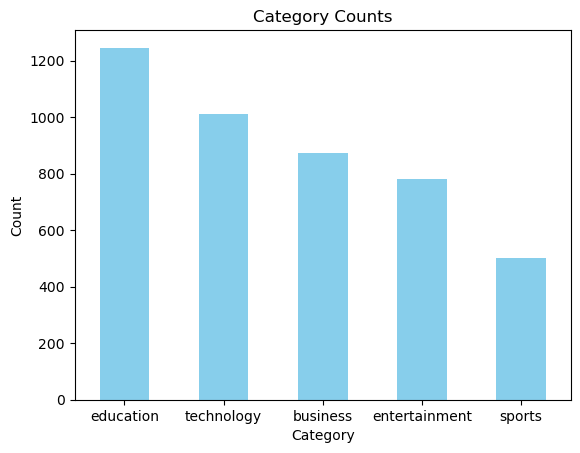

In [334]:
#Storing the count of each category, which will be used later for visualising them
category_counts = y_train.value_counts()

#Plotting a bar graph that shows the differing counts of each category
category_counts.plot(kind='bar', color='skyblue')
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


From this bar graph we can clearly see that there is a class imbalance within the training data. If not addressed, this could lead the model to being good at predicting the majority categories (education and technology) and not so much the minorities (sports and entertainment). To ensure that the model is equally effectivce at predicting all the categories, we will implement both upsampling and downsampling on the categories below.

<h4>Sampling</h4>

In [338]:
# Combine the training data into a single DataFrame
train_data = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())
train_data['category'] = y_train

# Separate each class (education, sports, technology, entertainment, business)
education_data = train_data[train_data['category'] == 'education']
sports_data = train_data[train_data['category'] == 'sports']
technology_data = train_data[train_data['category'] == 'technology']
entertainment_data = train_data[train_data['category'] == 'entertainment']
business_data = train_data[train_data['category'] == 'business']


In [340]:
# Define the list of categories
categories = ['education', 'sports', 'technology', 'entertainment', 'business']

# Define the target size for each class
target_len = int(len(y_train) / len(y_train.unique()))

# Iterate through each class to downsample or upsample based on size
balanced_data = []

for category in categories:
    # Separate the data for the current category
    category_data = train_data[train_data['category'] == category]
    
    # If the class size is greater than the target size, downsample
    if len(category_data) > target_len:
        downsampled_class = resample(category_data, 
                                     replace=False,  # Sample without replacement
                                     n_samples=target_len,  # Reduce to target size
                                     random_state=42)
        balanced_data.append(downsampled_class)
    
    # If the class size is less than the target size, upsample
    elif len(category_data) < target_len:
        upsampled_class = resample(category_data, 
                                   replace=True,  # Sample with replacement
                                   n_samples=target_len,  # Increase to target size
                                   random_state=42)
        balanced_data.append(upsampled_class)
    
    # If the class size is exactly the target size, just append it as is
    else:
        balanced_data.append(category_data)

# Combine all balanced class data
final_balanced_data = pd.concat(balanced_data)


In [341]:
X_train = final_balanced_data.drop(columns = ['category'])
y_train = final_balanced_data['category']

In [342]:
y_train.value_counts()

category
education        883
sports           883
technology       883
entertainment    883
business         883
Name: count, dtype: int64

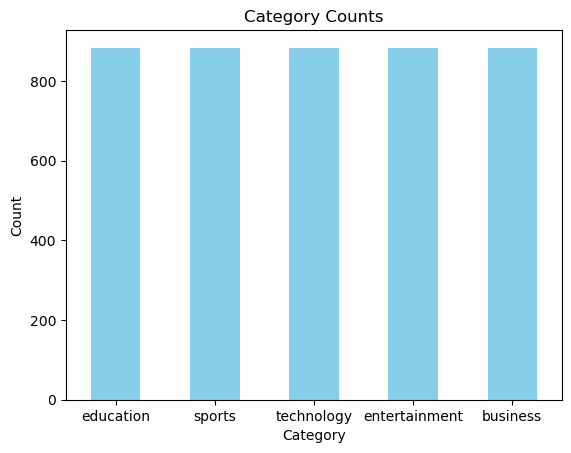

In [343]:
category_counts = y_train.value_counts()

category_counts.plot(kind='bar', color='skyblue')
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


As we can see, all the categories have been resampled to where they have the same number of observations.

<h1>Models</h1>

<h2>Neural Network</h2>

In [348]:
# Convert sparse matrix to dense numpy array
X_train = X_train.toarray() if isinstance(X_train, csr_matrix) else X_train
X_val = X_val.toarray() if isinstance(X_val, csr_matrix) else X_val
X_test = X_test.toarray() if isinstance(X_test, csr_matrix) else X_test

# # Now slice the dense arrays to keep only the first 499 columns
X_val = X_val[:, :4999]
X_test = X_test[:, :4999]


In [350]:
# Initialise the label encoder
label_encoder = LabelEncoder()

# Fit the encoder on the training labels and transform them
y_train_nn = label_encoder.fit_transform(y_train)
y_val_nn = label_encoder.transform(y_val)
y_test_nn = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_nn = to_categorical(y_train_nn)
y_val_nn = to_categorical(y_val_nn)
y_test_nn = to_categorical(y_test_nn)


In [352]:
# Hyperparameters
input_dims = X_train.shape[1]
batch_size = 32
epochs = 10
num_classes = len(y_train.unique())


In [354]:
#Creating the Neural network
model_nn = Sequential([
    Dense(4999, activation='relu', input_dim=input_dims),  # Input Layer
    Dropout(0.3),  # Regularization
    Dense(4500, activation='relu'),  # First hidden layer
    Dropout(0.2),  # Regularization
    Dense(3500, activation='relu'),  # Second hidden layer
    Dropout(0.2),  # Regularization
    Dense(3000, activation='relu'),  # Third hidden layer
    Dropout(0.2),  # Regularization
    Dense(2000, activation='relu'),  # Fourth hidden layer
    Dropout(0.2),  # Regularization
    Dense(1000, activation='relu'),  # Fifth hidden layer
    Dropout(0.2),  # Regularization
    Dense(500, activation='relu'),  # Sixth hidden layer
    Dropout(0.2),  # Regularization
    Dense(100, activation='relu'),  # Seventh hidden layer
    Dropout(0.2),  # Regularization
    Dense(num_classes, activation='softmax')  # Output layer for classification
])

<h4>Training</h4>

In [356]:
# Compile the model
model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [358]:
history = model_nn.fit(X_train, y_train_nn, validation_data=(X_val, y_val_nn), epochs=epochs, batch_size=batch_size)

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.2531 - loss: 1.5225 - val_accuracy: 0.1223 - val_loss: 1.8538
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.4656 - loss: 1.1265 - val_accuracy: 0.2047 - val_loss: 2.1721
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.6466 - loss: 0.8148 - val_accuracy: 0.2219 - val_loss: 3.2227
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8091 - loss: 0.5214 - val_accuracy: 0.2192 - val_loss: 2.8839
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8904 - loss: 0.3574 - val_accuracy: 0.2147 - val_loss: 4.2200
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9322 - loss: 0.2248 - val_accuracy: 0.2446 - val_loss: 4.0189
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.9487 - loss: 0.1716 - val_accuracy: 0.2237 - val_loss: 8.7559
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9599 - loss: 0.1725 - val_accu

<h4>Evaluation</h4>

In [360]:
# Now evaluate the model (do not overwrite model_nn with history)
test_loss, test_accuracy = model_nn.evaluate(X_test, y_test_nn, batch_size=32)

# Print results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.2108 - loss: 6.0261
Test Loss: 6.086636543273926
Test Accuracy: 0.20749999582767487


<h4>Model Tuning</h4>

In [362]:
def create_nn_model(optimizer='adam', dropout_rate=0.2, num_units=64):
    model = Sequential([
        Dense(4999, activation='relu', input_dim=input_dims),
        Dropout(0.3),
        Dense(4500, activation='relu'),
        Dropout(0.2), 
        Dense(3500, activation='relu'),
        Dropout(0.2),
        Dense(3000, activation='relu'),
        Dropout(0.2),
        Dense(2000, activation='relu'),
        Dropout(0.2),
        Dense(1000, activation='relu'), 
        Dropout(0.2),
        Dense(500, activation='relu'),
        Dropout(0.2), 
        Dense(100, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax') 
    ])
    # Compile model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    

In [223]:
model_nn_tune = KerasClassifier(build_fn=create_nn_model, epochs=10, batch_size=32, verbose=0, dropout_rate=0.2)


In [225]:
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.2, 0.3, 0.5],
    'batch_size': [32, 64],
    'epochs': [10, 20, 30],
    'loss': ['categorical_crossentropy', 'binary_crossentropy']
}


Running the following code cell will take a while as it is going a while as it is performing a significant number of tests in an attenmpt to to find the best combination of parameters that will yield the best performing neural network 

In [ ]:
#Using GridSearchCV to get the best hyperparameters for the NN model
grid_search = GridSearchCV(estimator=model_nn_tune, param_grid=param_grid, n_jobs=-1, cv=5)
grid_search.fit(X_train, y_train_nn)

# Get the best hyperparameters
print("Best parameters found: ", grid_search.best_params_)

<h4>Testing the 'best' model</h4>

In [364]:
model_best = Sequential([
    Input(shape=(X_train.shape[1],)),  
    Dense(4999, activation='relu'),
    Dropout(0.3),
    Dense(4500, activation='relu'),
    Dropout(0.2), 
    Dense(3500, activation='relu'),
    Dropout(0.2),
    Dense(3000, activation='relu'),
    Dropout(0.2),
    Dense(2000, activation='relu'),
    Dropout(0.2),
    Dense(1000, activation='relu'), 
    Dropout(0.2),
    Dense(500, activation='relu'),
    Dropout(0.2), 
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax') 
])

In [366]:
model_best.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [372]:
model_best.fit(X_train, y_train_nn, validation_data=(X_val, y_val_nn), epochs=epochs, batch_size=batch_size)

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.2166 - loss: 1.5929 - val_accuracy: 0.2092 - val_loss: 1.6504
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.4002 - loss: 1.2439 - val_accuracy: 0.1658 - val_loss: 2.1035
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5729 - loss: 0.8987 - val_accuracy: 0.2047 - val_loss: 2.8400
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.7011 - loss: 0.6231 - val_accuracy: 0.2301 - val_loss: 2.9551
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.8184 - loss: 0.4535 - val_accuracy: 0.2292 - val_loss: 3.1324
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9078 - loss: 0.3145 - val_accuracy: 0.1911 - val_loss: 3.1580
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.9561 - loss: 0.2375 - val_accuracy: 0.2147 - val_loss: 4.5481
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9620 - loss: 0.1669 - val_accu

In [373]:
test_loss, test_accuracy = model_best.evaluate(X_test, y_test_nn, batch_size=32)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.2101 - loss: 8.9889
Test Loss: 8.88204574584961
Test Accuracy: 0.20800000429153442


<h4>MLFlow</h4>

The following function will, using MLFlow, create an experiment that will track the model passed to it, and log its parameters and metrics

In [376]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [378]:
def train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, model, model_name):

    with mlflow.start_run(run_name = model_name):
        # Log hyperparameters
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("input_dims", input_dims)
        mlflow.log_param("num_classes", num_classes)

        # Train the model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                               validation_data=(X_val, y_val), verbose=1)

        # Log final validation metrics
        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
        mlflow.log_metric("val_loss", val_loss)
        mlflow.log_metric("val_accuracy", val_accuracy)

        # Evaluate on test data
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        mlflow.log_metric("test_loss", test_loss)
        mlflow.log_metric("test_accuracy", test_accuracy)

        # Make predictions on test set
        y_pred = model.predict(X_test)
        y_pred_classes = y_pred.argmax(axis=1)
        y_true_classes = y_test.argmax(axis=1)

        # Generate classification report
        report = classification_report(y_true_classes, y_pred_classes, output_dict=True)
        mlflow.log_dict(report, "classification_report.json")

        # #logging the model
        signature = infer_signature(X_train.iloc[:5].to_numpy(), model.predict(X_train.iloc[:5].to_numpy()))
        mlflow.keras.log_model(model, "Neural Network model", signature=signature)

    return model

In [380]:
train_and_evaluate_model(X_train, y_train_nn, X_val, y_val_nn, X_test, y_test_nn, model_nn, model_name = "Base Model")

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.9737 - loss: 0.1877 - val_accuracy: 0.2518 - val_loss: 5.5096
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9736 - loss: 0.1001 - val_accuracy: 0.2418 - val_loss: 6.4947
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9847 - loss: 0.0866 - val_accuracy: 0.2500 - val_loss: 4.8937
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.9806 - loss: 0.1057 - val_accuracy: 0.2418 - val_loss: 5.4778
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9887 - loss: 0.1021 - val_accuracy: 0.2464 - val_loss: 8.2185
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 97s 699ms/step - accuracy: 0.9884 - loss: 0.1210 - val_accuracy: 0.2246 - val_loss: 16.7374
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 97s 702ms/step - accuracy: 0.9865 - loss: 0.0617 - val_accuracy: 0.2409 - val_loss: 4.8960
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 108s 785ms/step - accuracy: 0.9948 - loss: 0.0326 - 

<Sequential name=sequential_18, built=True>

In [381]:
train_and_evaluate_model(X_train, y_train_nn, X_val, y_val_nn, X_test, y_test_nn, model_best, model_name = "Tuned Model")

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 120s 867ms/step - accuracy: 0.9737 - loss: 0.1383 - val_accuracy: 0.2274 - val_loss: 11.7914
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.9782 - loss: 0.1773 - val_accuracy: 0.2011 - val_loss: 7.2205
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.9724 - loss: 0.1247 - val_accuracy: 0.1812 - val_loss: 10.4630
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9843 - loss: 0.0744 - val_accuracy: 0.1902 - val_loss: 25.1676
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9888 - loss: 0.0509 - val_accuracy: 0.1775 - val_loss: 9.9322
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9849 - loss: 0.0697 - val_accuracy: 0.1839 - val_loss: 9.8404
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 127s 920ms/step - accuracy: 0.9814 - loss: 0.1429 - val_accuracy: 0.2092 - val_loss: 6.2444
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9841 - loss: 0.0906 -

<Sequential name=sequential_19, built=True>

Having looked at the models' performance on MLFlow, the tuned model outperformed the base model and now, it will be registered and saved for export and future use.

<h5>Registering the better performing model</h5>

In [389]:
model_name = "Tuned Model"
run_id = input("Enter Run ID: ") #"4cc744832cfa4cd3b3e2080144b83c84"
model_uri = f"runs:/{run_id}/{model_name}"

result = mlflow.register_model(
    model_uri, model_name
)

Enter Run ID:  02b8ea47d0074398a2767b6ab7b2be3e


Registered model 'Tuned Model' already exists. Creating a new version of this model...
2025/02/05 10:31:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Tuned Model, version 2
Created version '2' of model 'Tuned Model'.


In [413]:
with open("NN_model_compressed.pkl", "wb") as f:
    joblib.dump(model_best, f, compress=9) 

In [415]:
model = tf.keras.models.load_model("NN_model_compressed.pkl")

# Convert weights to float16
for layer in model.layers:
    if hasattr(layer, 'kernel'):
        layer.kernel.assign(tf.cast(layer.kernel, dtype=tf.float16))

# Save the smaller model
model.save("NN_model_compressed.h5")

ValueError: File format not supported: filepath=NN_model_compressed.pkl. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(NN_model_compressed.pkl, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [391]:
filename = "NN_model.pkl"
pickle.dump(model_best, open(filename, "wb"))

<h2>Random Forest</h2>

#### Training 

In [ ]:
rf_model = RandomForestClassifier(n_estimators=5, max_depth=3, min_samples_split=2, min_samples_leaf=1, random_state=42)
rf_model.fit(X_train, y_train)


#### Evaluation

In [ ]:
# Train and evaluate the Random Forest model
y_pred = rf_model.predict(X_val)

print("Accuracy Score:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

In [ ]:
#Converting the data into arrays to be used by the RandomSearchCV
X_train_rf = np.array(X_train)
y_train_rf = np.array(y_train)
X_test_rf = np.array(X_val)
y_test_rf = np.array(y_val)

# Define the parameter grid
param_grid = {
    'n_estimators': [3, 5, 10],  # Number of trees
    'max_depth': [3, 4, 5]  # Maximum depth of trees
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=5, max_depth=3, min_samples_split=2, min_samples_leaf=1, random_state=42)


In [ ]:
# Use RandomizedSearchCV for efficiency
random_search = RandomizedSearchCV(
    estimator=rf_model, 
    param_distributions=param_grid, 
    n_iter=10,  # Randomly sample 10 combinations
    cv=5, 
    n_jobs=1,  # Prevent memory issues
    verbose=2, 
    scoring='accuracy',
    random_state=42
)


In [ ]:
# Fit the model
random_search.fit(X_train_rf, y_train_rf)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Get the best parameters and model
best_rf_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)


#### Model Tuning

In [ ]:
# Predict on the test set
y_pred_optimized = best_rf_model.predict(X_test_rf)

# Evaluate the model
print("\nOptimized Accuracy Score:", accuracy_score(y_test_rf, y_pred_optimized))
print("\nOptimized Classification Report:\n", classification_report(y_test_rf, y_pred_optimized))


#### MLFlow

In [ ]:
#Setting the tracking URI, which is where MLFlow will run and log experiments
import mlflow
import mlflow.sklearn
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest(X_train, y_train, X_test, y_test, n_estimators, max_depth, min_samples_split,
                        min_samples_leaf, model_name=None, random_state=None):
    # Function code here

    experiment = mlflow.create_experiment(model_name)
    # Set MLflow experiment
    mlflow.set_experiment(f"{model_name}_random_forest_experiment")

    # Start a new MLflow run
    with mlflow.start_run():
        # Create the Random Forest model
        rf_model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state
        )
        
        # Train the model
        rf_model.fit(X_train_rf, y_train_rf)
        
        # Predict on test data
        y_pred = rf_model.predict(X_test_rf)
        
        # Log hyperparameters
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("min_samples_split", min_samples_split)
        mlflow.log_param("min_samples_leaf", min_samples_leaf)
        
        # Calculate and log accuracy as a metric
        accuracy = accuracy_score(y_test_rf, y_pred)
        mlflow.log_metric("accuracy", accuracy)
        
        # Optionally: Log the classification report as an artifact
        report = classification_report(y_test_rf, y_pred, output_dict=True)
        report_path = "classification_report.json"
        with open(report_path, "w") as f:
            json.dump(report, f)
        
        # Log the classification report as an artifact
        mlflow.log_artifact(report_path)
        
        # Log the trained model
        mlflow.sklearn.log_model(rf_model, "random_forest_model")
        
        # Optionally: Save the model as a .pkl file and log it
        model_path = "random_forest_model.pkl"
        joblib.dump(rf_model, model_path)
        mlflow.log_artifact(model_path)
        
        # Print and return the accuracy of the model
        print(f"Model training completed with accuracy: {accuracy}")
        return accuracy


In [ ]:
train_random_forest(X_train, y_train, X_test, y_test, 5, 3, 2, 1, model_name="base model 1", random_state=42)

In [ ]:
train_random_forest(X_train, y_train, X_test, y_test, 5, 3, 2, 1 , model_name="optimized model 1", random_state=42)

In [ ]:
import joblib
joblib.dump(best_rf_model, "optimized_rf_model.pkl")
print("Model saved as 'optimized_rf_model.pkl'")


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(best_rf_model, X_test_rf, y_test_rf, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(len(features))
print(len(importances))


In [ ]:
# Trim the importances array to match the number of features
importances = importances[:len(features)]


In [ ]:
# Create the DataFrame with feature names and importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the DataFrame by importance in descending order and take the top 10
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Display the top 10 most important features
print(importance_df)


<h2>K-Nearest Neighbours</h2>

In [36]:
X_train_knn = X_train
y_train_knn = y_train

X_test_knn = X_val
y_test_knn = y_val

#### Sparse matrices and transformation

In [37]:
from scipy.sparse import csr_matrix
X_train_sparse = csr_matrix(X_train_knn)
X_test_sparse = csr_matrix(X_test_knn)

scaler = StandardScaler(with_mean=False)  # Important for sparse matrices
X_train_scaled = scaler.fit_transform(X_train_sparse)
X_test_scaled = scaler.transform(X_test_sparse)

#### Evaluation

In [38]:
X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train_knn, y_train_knn, train_size=0.1, random_state=42)

In [39]:
# Train the KNN model (multi-label classification assumes one-vs-rest by default)
knn = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree')

In [40]:
knn.fit(X_train_scaled, y_train_knn)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=1)

In [41]:
y_pred_knn = knn.predict(X_test_scaled)


#### Model Tuning

In [44]:
#For the n neigbors = 3
from sklearn.metrics import accuracy_score

k_values = [1, 3, 5, 7, 9, 15, 20]

# List to store accuracy scores of each KNN model for comparison
scores = []

# Loop over each value of k 
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_sampled, y_train_sampled)
    y_pred_knn = knn.predict(X_test_scaled)
    accuracy = accuracy_score(y_test_knn, y_pred_knn)
    scores.append(accuracy)
    print(f"Accuracy for K={k}: {accuracy:.4f}")

Accuracy for K=1: 0.8442
Accuracy for K=3: 0.8786
Accuracy for K=5: 0.9085
Accuracy for K=7: 0.9203
Accuracy for K=9: 0.9339
Accuracy for K=15: 0.9529
Accuracy for K=20: 0.9466


In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
# List of k values to evaluate
k_values = [1, 3, 5, 7, 9, 15, 20]

# List to store metrics for comparison
metrics = {
    'k': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'log_loss': []  # Add log_loss to the metrics
}

# Loop over each value of k
for k in k_values:
    # Initialize and train the KNN model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_sampled, y_train_sampled)  # Use X_train_sampled instead of X_train_knn
    
    # Get predictions
    y_pred_knn = knn.predict(X_test_scaled)  # Use X_test_sampled instead of X_test_knn
    y_pred_proba_knn = knn.predict_proba(X_test_scaled)  # Predicted probabilities for log loss
    
    # Compute metrics
    accuracy = accuracy_score(y_test_knn, y_pred_knn)
    precision = precision_score(y_test_knn, y_pred_knn, average='weighted', zero_division=0)
    recall = recall_score(y_test_knn, y_pred_knn, average='weighted', zero_division=0)
    f1 = f1_score(y_test_knn, y_pred_knn, average='weighted')
    loss = log_loss(y_test_knn, y_pred_proba_knn)  # Log loss calculation
    
    # Store the metrics
    metrics['k'].append(k)
    metrics['accuracy'].append(accuracy)
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1_score'].append(f1)
    metrics['log_loss'].append(loss)  # Add log_loss to the list

# Convert metrics to DataFrame for tabular display
metrics_df = pd.DataFrame(metrics)

# Print the table
print(metrics_df)

# Find the best k based on accuracy and log loss
best_k_accuracy = metrics['k'][np.argmax(metrics['accuracy'])]  # Use np.argmax for accuracy
best_k_loss = metrics['k'][np.argmin(metrics['log_loss'])]  # Use np.argmin for log loss

print(f"\nBest performing K based on Accuracy: {best_k_accuracy}")
print(f"Best performing K based on Log Loss: {best_k_loss}")


    k  accuracy  precision    recall  f1_score  log_loss
0   1  0.844203   0.845237  0.844203  0.844261  5.615497
1   3  0.878623   0.882490  0.878623  0.878746  1.593428
2   5  0.908514   0.910900  0.908514  0.908508  1.035057
3   7  0.920290   0.921978  0.920290  0.920367  0.749809
4   9  0.933877   0.934763  0.933877  0.933903  0.518189
5  15  0.952899   0.953347  0.952899  0.952861  0.408178
6  20  0.946558   0.947645  0.946558  0.946602  0.435270

Best performing K based on Log Loss: 15


In [50]:
# Step 2: Define Hyperparameter Ranges for Tuning
param_grid = {
    'n_neighbors': [ 5,7, 9,15],          # Number of neighbors
    'weights': ['uniform', 'distance'],      # Weighting scheme
    'metric': ['euclidean', 'manhattan']     # Distance metrics
}

# Step 3: Initialize and Perform Grid Search
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train_knn)

# Step 4: Display the Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


In [51]:
best_knn = grid_search.best_estimator_
y_test_pred = best_knn.predict(X_test_scaled)

print("\nClassification Report (Test Dataset):")
print(classification_report(y_test_knn, y_test_pred))


Classification Report (Test Dataset):
               precision    recall  f1-score   support

     business       1.00      0.72      0.84       245
    education       0.52      1.00      0.68       274
entertainment       1.00      0.71      0.83       178
       sports       1.00      0.74      0.85       137
   technology       1.00      0.62      0.76       270

     accuracy                           0.77      1104
    macro avg       0.90      0.76      0.79      1104
 weighted avg       0.88      0.77      0.78      1104



#### MLFLow

In [52]:
import mlflow 

In [59]:
import mlflow
import mlflow.sklearn
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Step 1: Define Hyperparameter Ranges for Tuning
param_grid = {
    'n_neighbors': [5, 7, 9, 15],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weighting scheme
    'metric': ['euclidean', 'manhattan']  # Distance metrics
}

# Step 2: Initialize KNN and GridSearchCV
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=1)

# Step 3: Fit the GridSearchCV on the training data
grid_search.fit(X_train_scaled, y_train_knn)

# Step 4: Display the Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Step 5: Log the best model to MLflow
with mlflow.start_run():
    mlflow.sklearn.log_model(grid_search.best_estimator_, "knn_model")

    # Log the accuracy of the model
    accuracy = accuracy_score(y_test_knn, grid_search.best_estimator_.predict(X_test_scaled))
    mlflow.log_metric("accuracy", accuracy)

    print(f"Logged best KNN model with accuracy: {accuracy:.4f} to MLflow")

# Step 6: Save the best model locally using joblib
joblib.dump(grid_search.best_estimator_, "best_knn_model.pkl")
print("Best KNN model saved locally as 'best_knn_model.pkl'")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


2025/01/31 06:46:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged best KNN model with accuracy: 0.7663 to MLflow
Best KNN model saved locally as 'best_knn_model.pkl'


<h2>Naive Bayes</h2>